In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

In [2]:
import regressor
import utils

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Read data

In [4]:
metadata = pd.read_csv('../data/plasticc/plasticc_train_metadata.csv.gz')
data = pd.read_csv('../data/plasticc/plasticc_train_lightcurves.csv.gz')

data = data[data.detected_bool == 1]

In [5]:
metadata.head()

,object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,...,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,615,349.0461,-61.9438,1,0.000,0.000,0.000,-9.000,0.017,92,...,0.0,0.0,59570.000,69,484.7,3286.7,3214.1,3039.7,2854.5,2837.0
1,713,53.0859,-27.7844,1,1.818,1.627,0.255,45.406,0.007,88,...,0.0,0.0,59570.000,34,108.7,117.7,119.9,149.6,147.9,150.5
2,730,33.5742,-6.5796,1,0.232,0.226,0.016,40.256,0.021,42,...,0.0,0.0,60444.379,9,0.0,0.0,0.0,0.0,0.0,0.0
3,745,0.1899,-45.5867,1,0.304,0.281,1.152,40.795,0.007,90,...,0.0,0.0,60130.453,38,0.0,0.0,0.0,0.0,0.0,0.0
4,1124,352.7113,-63.8237,1,0.193,0.241,0.018,40.417,0.024,90,...,0.0,0.0,60452.641,1,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
data.head()

,object_id,mjd,passband,flux,flux_err,detected_bool
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [7]:
object_ids = np.unique(data.object_id)

In [8]:
passband2name = {0: 'u', 1: 'g', 2: 'r', 3: 'i', 4: 'z', 5: 'y'}
passband2lam  = {0: np.log10(3751.36), 1: np.log10(4741.64), 2: np.log10(6173.23), 
                 3: np.log10(7501.62), 4: np.log10(8679.19), 5: np.log10(9711.53)}

# Visual analysis

In [9]:
def get_object(data, object_id):
    anobject = data[data.object_id == object_id]
    return anobject

In [10]:
def get_passband(anobject, passband):
    light_curve = anobject[anobject.passband == passband]
    return light_curve

In [11]:
def add_log_lam(anobject):
    passbands = anobject.passband.values
    log_lam = [passband2lam[i] for i in passbands]
    anobject['log_lam'] = log_lam
    return anobject

In [12]:
def create_approx_object(anobject, n=1000):
    mjd = anobject['mjd'].values
    dfs = []
    for passband in range(6):
        df = pd.DataFrame()
        df['mjd'] = np.linspace(mjd.min(), mjd.max(), n)
        df['object_id'] = 0
        df['passband'] = passband
        df['flux'] = 0
        df['flux_err'] = 0
        df['detected_bool'] = 1
        dfs.append(df)
    new_object = pd.concat(dfs, axis=0)
    new_object = add_log_lam(new_object)
    return new_object

In [13]:
def is_good(anobject):
    good = 1
    
    # remove all objects with negative flux values
    if anobject['flux'].values.min() < 0:
        good = 0
    
    # keep only objects with at least 10 observations in at least 3 passbands
    count = 0
    for passband in range(6):
        if len(get_passband(anobject, passband)) < 10:
            count += 1
    if count > 3:
        good = 0
        
    # keep only objects without large breaks in observations
    anobject = anobject.sort_values('mjd')
    mjd = anobject['mjd'].values
    if np.diff(mjd, 1).max() > 50:
        good = 0
    
    return good

In [14]:
def plot_light_curves(anobject, title=""):
    anobject = anobject.sort_values('mjd')
    plt.figure(figsize=(9, 4))
    for passband in range(6):
        light_curve = get_passband(anobject, passband)
        plt.plot(light_curve['mjd'].values, light_curve['flux'].values, linewidth=0.5)
        plt.scatter(light_curve['mjd'].values, light_curve['flux'].values, label=passband2name[passband], linewidth=1)
    plt.xlabel('Modified Julian Date', size=14)
    plt.xticks(size=14)
    plt.ylabel('Flux', size=14)
    plt.yticks(size=14)
    plt.grid()
    plt.legend(loc='best', ncol=3, fontsize=14)
    plt.title(title, size=14)

34299


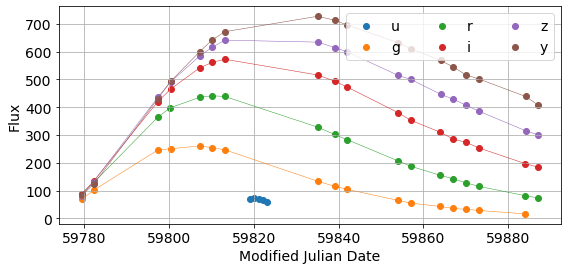

43812


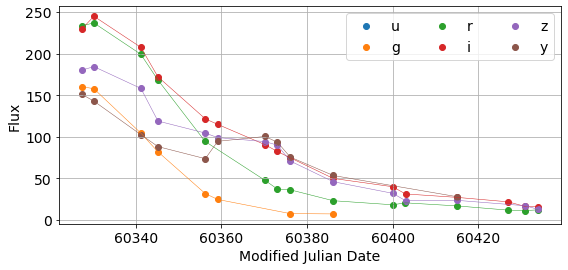

70046


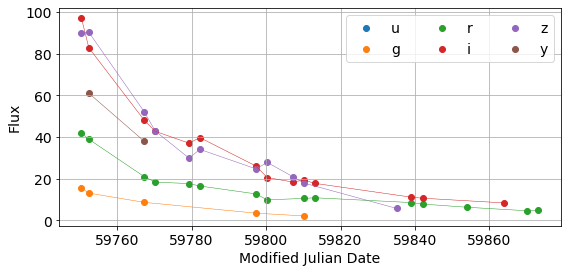

84716


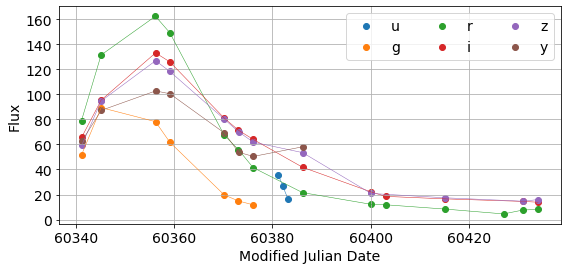

131629


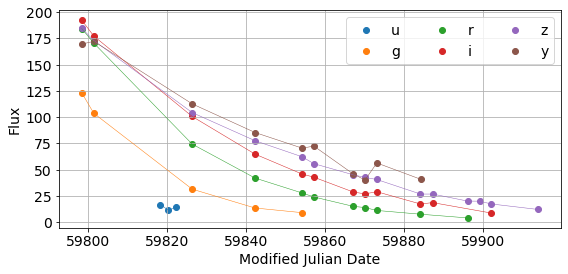

169315


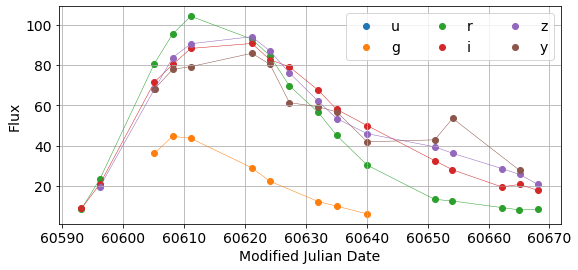

229855


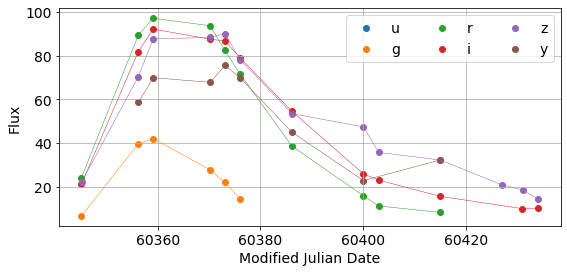

251430


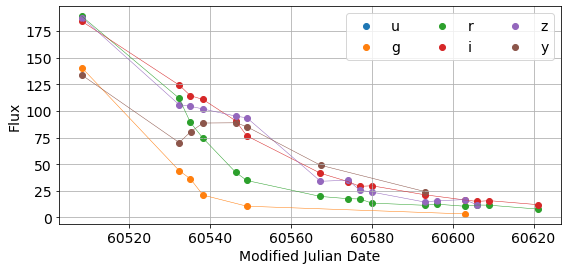

282714


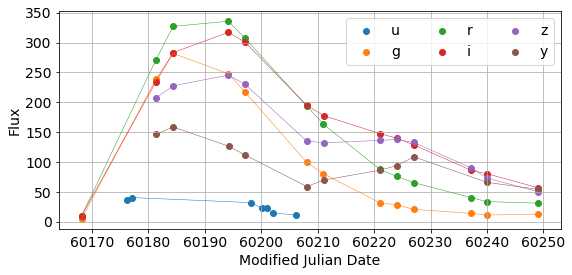

290682


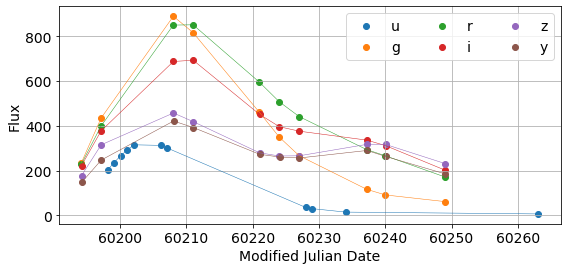

316306


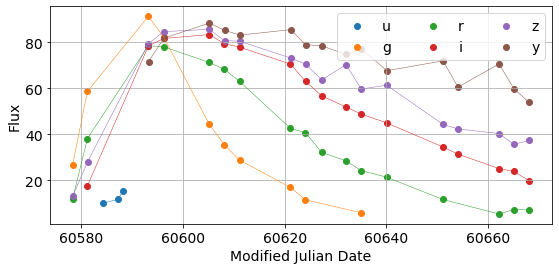

In [15]:
for i in object_ids[::50]:
    anobject = get_object(data, i)
    
    if not is_good(anobject): continue
    print(i)
    
    plot_light_curves(anobject)
    plt.show()

# One object test Test

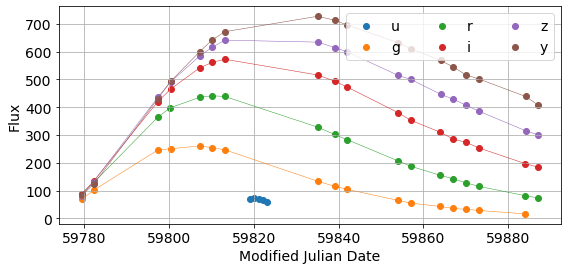

In [16]:
anobject = get_object(data, 34299)
anobject = add_log_lam(anobject)

plot_light_curves(anobject)
# plt.savefig('light_curve_34299.pdf', format='pdf')

In [17]:
MODEL = "GP"

In [18]:
# train / test split
from sklearn.model_selection import train_test_split
anobject_train, anobject_test = train_test_split(anobject, test_size=0.5, random_state=11)

X_train = anobject_train[['mjd', 'log_lam']].values
X_test = anobject_test[['mjd', 'log_lam']].values

y_train = anobject_train['flux'].values
y_test  = anobject_test['flux'].values

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

# fit a regression model to approximate light curves
if MODEL == "XGB":
    from xgboost import XGBRegressor
    reg = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, objective='reg:squarederror')
elif MODEL == "NN":
    reg = regressor.FitNNRegressor(n_hidden=200, n_epochs=100, batch_size=1, lr=0.01, lam=0.01, optimizer='RMSprop')
elif MODEL == "Linear":
    from sklearn.linear_model import LinearRegression
    reg = LinearRegression()
elif MODEL == "GP":
    from sklearn.gaussian_process import GaussianProcessRegressor
    from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, WhiteKernel, ConstantKernel as C
    kernel = C(1.0) * RBF([1.0, 1.0]) + WhiteKernel()
    reg = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=5, optimizer="fmin_l_bfgs_b", random_state=42)

reg.fit(X_train_ss, y_train)

# predict flux for unseen observations
anobject_test_pred = anobject_test.copy()
anobject_test_pred['flux'] = np.maximum(reg.predict(X_test_ss), 0)

# predict flux for known observations
anobject_train_pred = anobject_train.copy()
anobject_train_pred['flux'] = np.maximum(reg.predict(X_train_ss), 0)

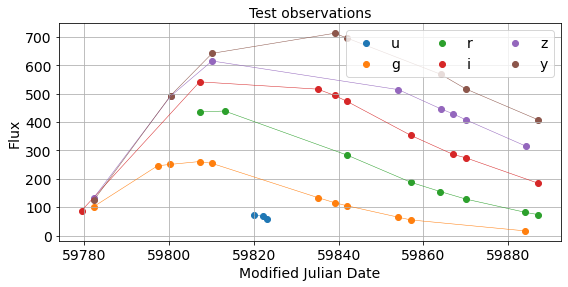

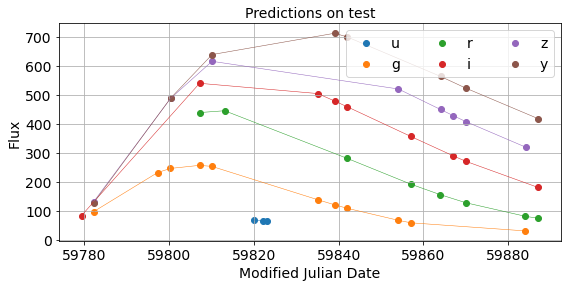

In [19]:
plot_light_curves(anobject_test, "Test observations")
plot_light_curves(anobject_test_pred, "Predictions on test")

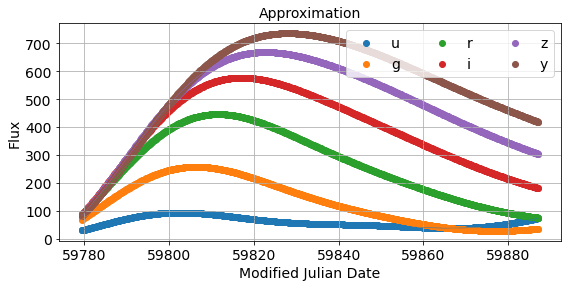

In [20]:
approx_object = create_approx_object(anobject)
X = approx_object[['mjd', 'log_lam']].values
X_ss = ss.transform(X)
approx_object['flux'] = reg.predict(X_ss)
plot_light_curves(approx_object, "Approximation")
# plt.savefig('approx_light_curve_34299.pdf', format='pdf')

In [21]:
# calculate quality metrics
[rmse, mae, rse, rae, mape] = utils.regression_quality_metrics_report(anobject_test['flux'].values, 
                                                                      anobject_test_pred['flux'].values)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("RSE: ", rse)
print("RAE: ", rae)
print("MAPE: ", mape)

RMSE:  5.857324341476709
MAE:  4.476286095738697
RSE:  0.029564557791260684
RAE:  0.025562145745649644
MAPE:  4.086987068423327


# Test on many objects

In [35]:
good_object_ids = [idx for idx in object_ids if is_good(get_object(data, idx))]

In [37]:
gp_report = pd.DataFrame(columns=["ID", 'RMSE', 'MAE', 'RSE', 'RAE', 'MAPE'])

for i in tqdm.tqdm_notebook(good_object_ids):
    
    # get an object
    anobject = get_object(data, i)
    anobject = add_log_lam(anobject)
    
    # train / test split
    anobject_train, anobject_test = train_test_split(anobject, test_size=0.5, random_state=11)
    
    X_train = anobject_train[['mjd', 'log_lam']].values
    X_test  = anobject_test[['mjd', 'log_lam']].values

    y_train = anobject_train['flux'].values
    y_test  = anobject_test['flux'].values

    from sklearn.preprocessing import StandardScaler
    ss = StandardScaler()
    X_train_ss = ss.fit_transform(X_train)
    X_test_ss = ss.transform(X_test)

    # fit a regression model to approximate light curves
    if MODEL == "XGB":
        from xgboost import XGBRegressor
        reg = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, objective='reg:squarederror')
    elif MODEL == "NN":
        reg = regressor.FitNNRegressor(n_hidden=100, n_epochs=100, batch_size=1, lr=0.01, lam=0.01, optimizer='Adam')
    elif MODEL == "Linear":
        from sklearn.linear_model import LinearRegression
        reg = LinearRegression()
    elif MODEL == "GP":
        from sklearn.gaussian_process import GaussianProcessRegressor
        from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, WhiteKernel, ConstantKernel as C
        kernel = C(1.0) * RBF([1.0, 1.0]) + WhiteKernel()
        reg = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=0, optimizer="fmin_l_bfgs_b", random_state=42)

    reg.fit(X_train_ss, y_train)

    
    # predict flux for unseen observations
    anobject_test_pred = anobject_test.copy()
    anobject_test_pred['flux'] = np.maximum(reg.predict(X_test_ss), 0)
    
    metrics = utils.regression_quality_metrics_report(anobject_test['flux'].values, anobject_test_pred['flux'].values)
    gp_report.loc[len(gp_report), :] = [i] + list(metrics)
np.round(gp_report.mean(), 2)

ID      340898.23
RMSE        25.63
MAE         14.25
RSE          0.24
RAE          0.20
MAPE        24.05
dtype: float64

In [114]:
def plot_loghist(x, bins, **kwargs):
    """
    https://stackoverflow.com/questions/47850202/plotting-a-histogram-on-a-log-scale-with-matplotlib?rq=1
    """
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.hist(x, bins=logbins, **kwargs)
    plt.xscale('log')
    
def plot_metrics_histogram(report, **hist_kwargs):
    plt.figure(figsize=(20, 20))
    for idx, metric in enumerate(report.columns[1:], 1):
        plt.subplot(3, 2, idx)
        plot_loghist(report[metric], bins=50)
        plt.xlabel(metric, size=14)
        plt.xticks(size=14)
        plt.yticks(size=14)
        plt.xscale('log')
        plt.grid()
    plt.show()
    
def plot_mult_metrics_histogram(reports, names=None, bins=15, **hist_kwargs):
    if names is None:
        names = range(len(reports))
    plt.figure(figsize=(20, 20))
    for idx, metric in enumerate(reports[0].columns[1:], 1):
        _, gen_bins = np.histogram(np.array([rep[metric] for rep in reports]).flatten() * 1.1, bins=bins)
        logbins = np.logspace(np.log10(gen_bins[0]),np.log10(gen_bins[-1]),len(gen_bins))
        plt.subplot(3, 2, idx)
        for n, report in enumerate(reports):
            plt.hist(report[metric], bins=logbins, alpha=1/2, label=names[n])
        plt.xlabel(metric, size=14)
        plt.xticks(size=14)
        plt.yticks(size=14)
        plt.xscale('log')
        plt.grid()
        plt.legend(fontsize=14)
    plt.show()

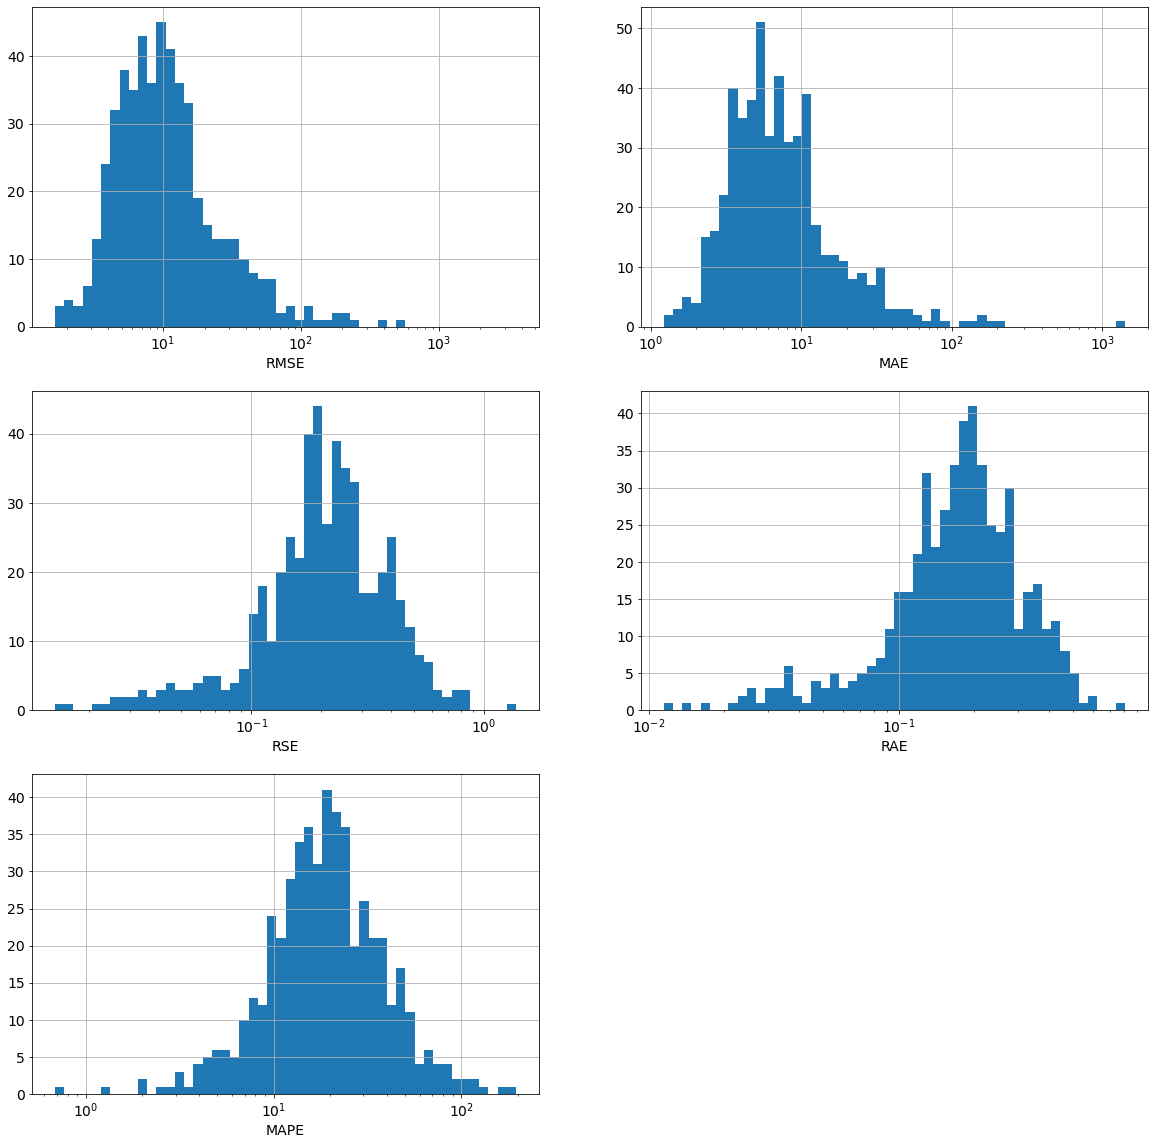

In [45]:
plot_metrics_histogram(gp_report)

In [46]:
gp_report

,ID,RMSE,MAE,RSE,RAE,MAPE
0,745,7.51382,6.08659,0.14354,0.164604,23.241
1,1124,3.62059,2.87321,0.0973731,0.107344,16.9564
2,1920,13.0414,6.66957,0.21084,0.133422,21.8057
3,2922,13.0521,9.08994,0.188624,0.258247,34.9227
4,4173,3.20002,2.39076,0.0645382,0.0582587,8.2348
...,...,...,...,...,...,...
511,339169,3.35663,2.32216,0.225573,0.179736,11.3039
512,341653,19.6847,12.3803,0.660082,0.489056,49.9561
513,342659,9.40354,5.02094,0.276737,0.18035,21.2268
514,8366012,41.4606,28.2179,0.33994,0.256247,64.9027


# NN

In [47]:
import importlib
import tqdm
importlib.reload(regressor)

<module 'regressor' from '/home/sysak_ma/Desktop/Study/Diploma/light_curve_approx/notebooks/regressor.py'>

In [48]:
nn_report = pd.DataFrame(columns=["ID", 'RMSE', 'MAE', 'RSE', 'RAE', 'MAPE'])

for i in tqdm.tqdm_notebook(good_object_ids):
    
    # get an object
    anobject = get_object(data, i)
    anobject = add_log_lam(anobject)
    
    # train / test split
    anobject_train, anobject_test = train_test_split(anobject, test_size=0.5, random_state=11)
    
    X_train = anobject_train[['mjd', 'log_lam']].values
    X_test  = anobject_test[['mjd', 'log_lam']].values

    y_train = anobject_train['flux'].values
    y_test  = anobject_test['flux'].values

    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import StandardScaler, PolynomialFeatures

    ss = StandardScaler()
    X_train_ss = ss.fit_transform(X_train)
    X_test_ss = ss.transform(X_test)

    # fit a regression model to approximate light curves
    reg = regressor.FitNNRegressor(n_hidden=300, n_epochs=200, batch_size=200, lr=0.1, lam=0.1, optimizer='Adam', debug=0)

    reg.fit(X_train_ss, y_train)

    
    # predict flux for unseen observations
    anobject_test_pred = anobject_test.copy()
    anobject_test_pred['flux'] = np.maximum(reg.predict(X_test_ss), 0)
    
    metrics = utils.regression_quality_metrics_report(anobject_test['flux'].values, anobject_test_pred['flux'].values)
    nn_report.loc[len(nn_report), :] = [i] + list(metrics)
np.round(nn_report.mean(), 2)

ID      340898.23
RMSE        21.06
MAE         12.48
RSE          0.25
RAE          0.20
MAPE        17.27
dtype: float64

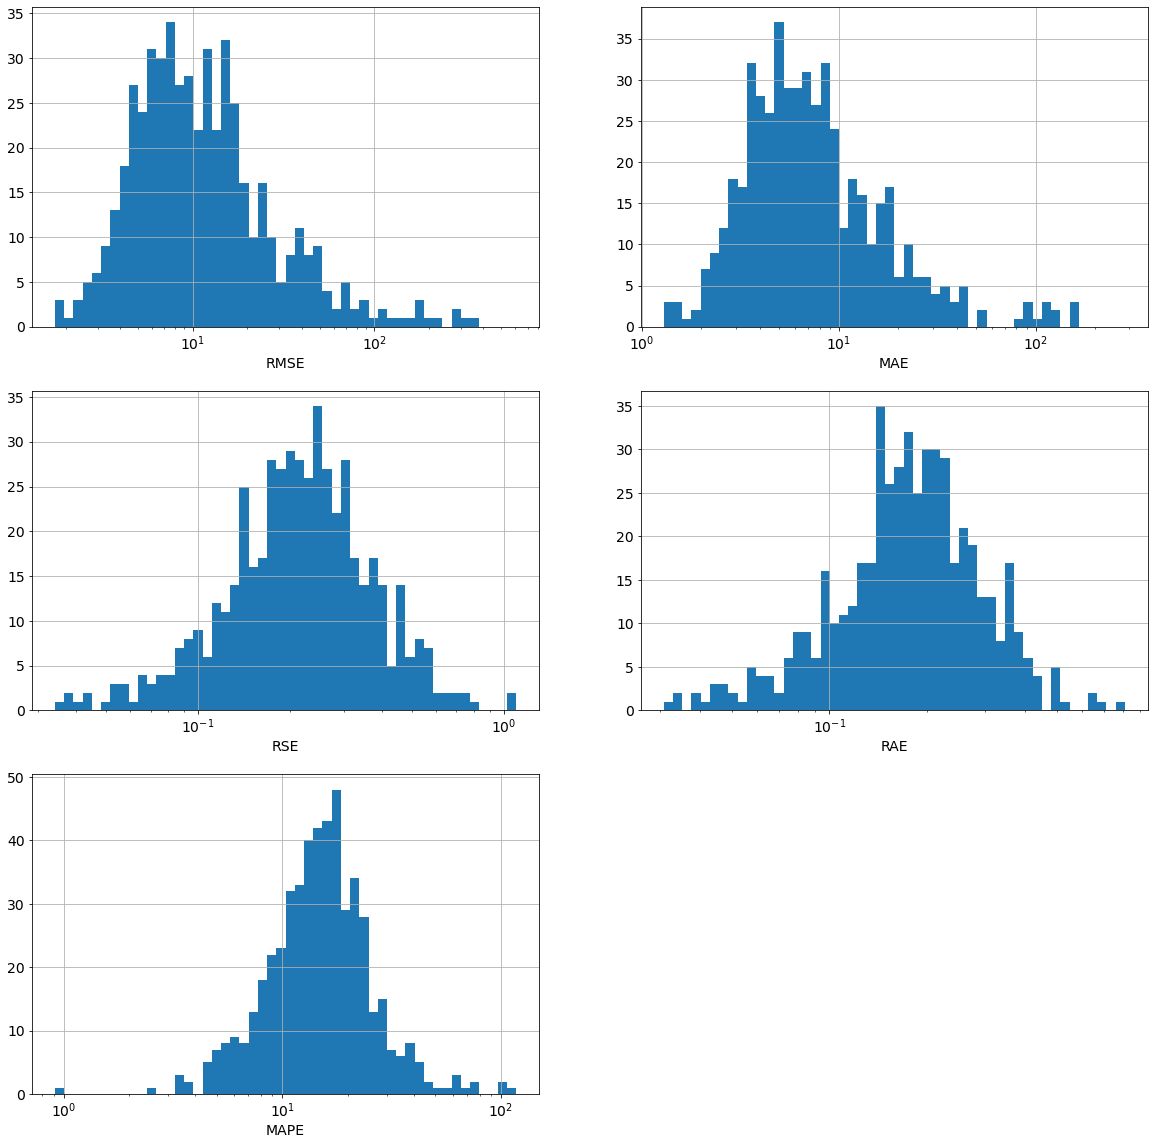

In [49]:
plot_metrics_histogram(nn_report)

In [51]:
nn_report

,ID,RMSE,MAE,RSE,RAE,MAPE
0,745,8.20007,5.45462,0.156649,0.147514,16.4944
1,1124,5.2438,3.75677,0.141028,0.140354,17.4495
2,1920,16.876,10.6146,0.272835,0.212342,21.2537
3,2922,16.6717,9.55255,0.240933,0.27139,19.9766
4,4173,4.13774,3.21606,0.0834501,0.0783697,10.1609
...,...,...,...,...,...,...
511,339169,4.17306,2.78308,0.280439,0.215412,11.5737
512,341653,5.33031,3.81887,0.17874,0.150856,8.59332
513,342659,6.11579,4.03487,0.179982,0.144931,13.4786
514,8366012,68.0717,40.8808,0.558127,0.371239,73.8179


In [92]:
nn_report.RMSE.max(), gp_report.RMSE.max()

(605.4306383535389, 3636.750567161653)

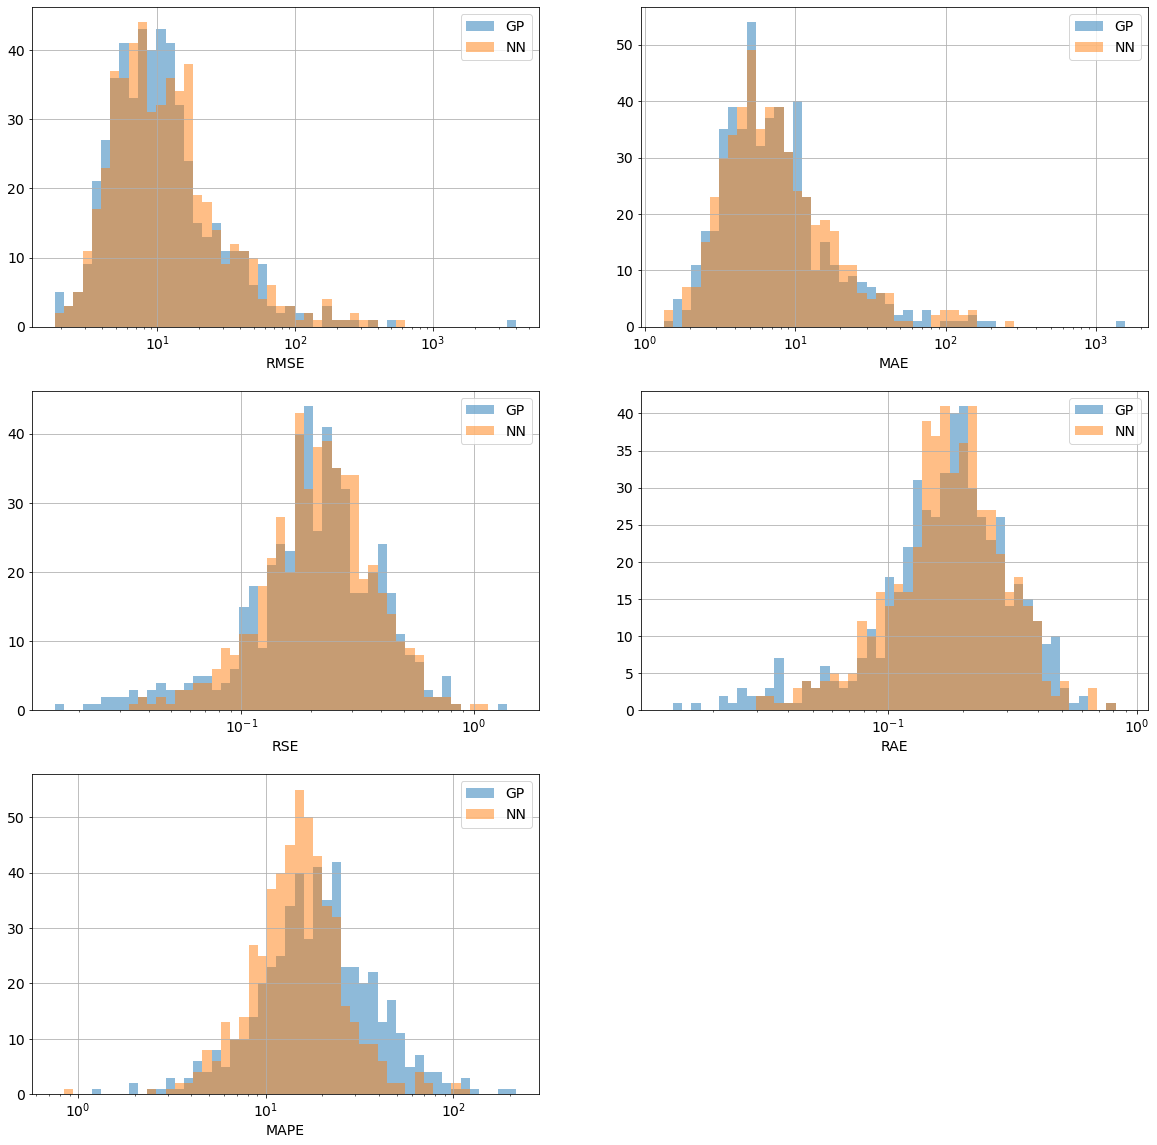

In [115]:
plot_mult_metrics_histogram([gp_report, nn_report], ['GP', 'NN'], bins=50)

# XGBoost

In [116]:
from xgboost import XGBRegressor

In [117]:
xgb_report = pd.DataFrame(columns=["ID", 'RMSE', 'MAE', 'RSE', 'RAE', 'MAPE'])

for i in tqdm.tqdm_notebook(good_object_ids):
    
    # get an object
    anobject = get_object(data, i)
    anobject = add_log_lam(anobject)
    
    # train / test split
    anobject_train, anobject_test = train_test_split(anobject, test_size=0.5, random_state=11)
    
    X_train = anobject_train[['mjd', 'log_lam']].values
    X_test  = anobject_test[['mjd', 'log_lam']].values

    y_train = anobject_train['flux'].values
    y_test  = anobject_test['flux'].values

    X_train_ss = X_train
    X_test_ss = X_test

    # fit a regression model to approximate light curves
    reg = XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=10, objective='reg:squarederror')

    reg.fit(X_train_ss, y_train)

    
    # predict flux for unseen observations
    anobject_test_pred = anobject_test.copy()
    anobject_test_pred['flux'] = np.maximum(reg.predict(X_test_ss), 0)
    
    metrics = utils.regression_quality_metrics_report(anobject_test['flux'].values, anobject_test_pred['flux'].values)
    xgb_report.loc[len(xgb_report), :] = [i] + list(metrics)
np.round(xgb_report.mean(), 2)

ID      340898.23
RMSE        36.87
MAE         22.09
RSE          0.39
RAE          0.32
MAPE        30.03
dtype: float64

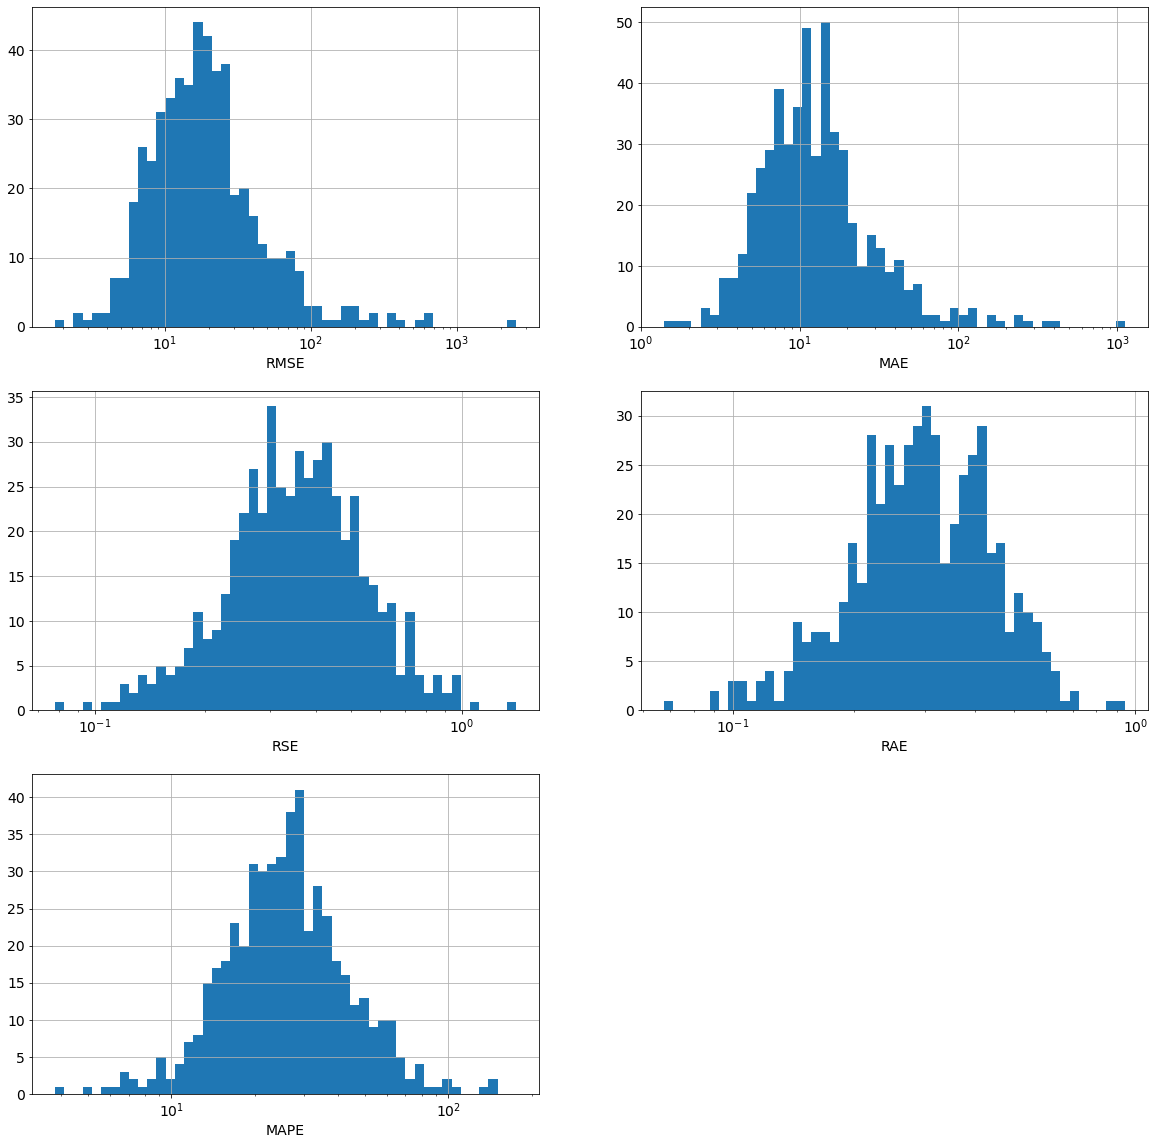

In [118]:
plot_metrics_histogram(xgb_report)

In [119]:
xgb_report

,ID,RMSE,MAE,RSE,RAE,MAPE
0,745,10.8867,7.46703,0.207974,0.201937,21.9599
1,1124,5.01335,3.95291,0.13483,0.147682,21.3562
2,1920,17.327,11.713,0.280127,0.234315,17.1048
3,2922,97.32,33.1372,1.40643,0.941434,102.576
4,4173,11.6074,8.43588,0.234098,0.205567,15.7213
...,...,...,...,...,...,...
511,339169,6.82631,5.04716,0.458744,0.390652,18.6312
512,341653,14.1376,9.95831,0.474074,0.393381,41.2782
513,342659,28.5756,14.9225,0.840954,0.53601,52.1037
514,8366012,75.3021,53.0519,0.61741,0.481765,84.1702


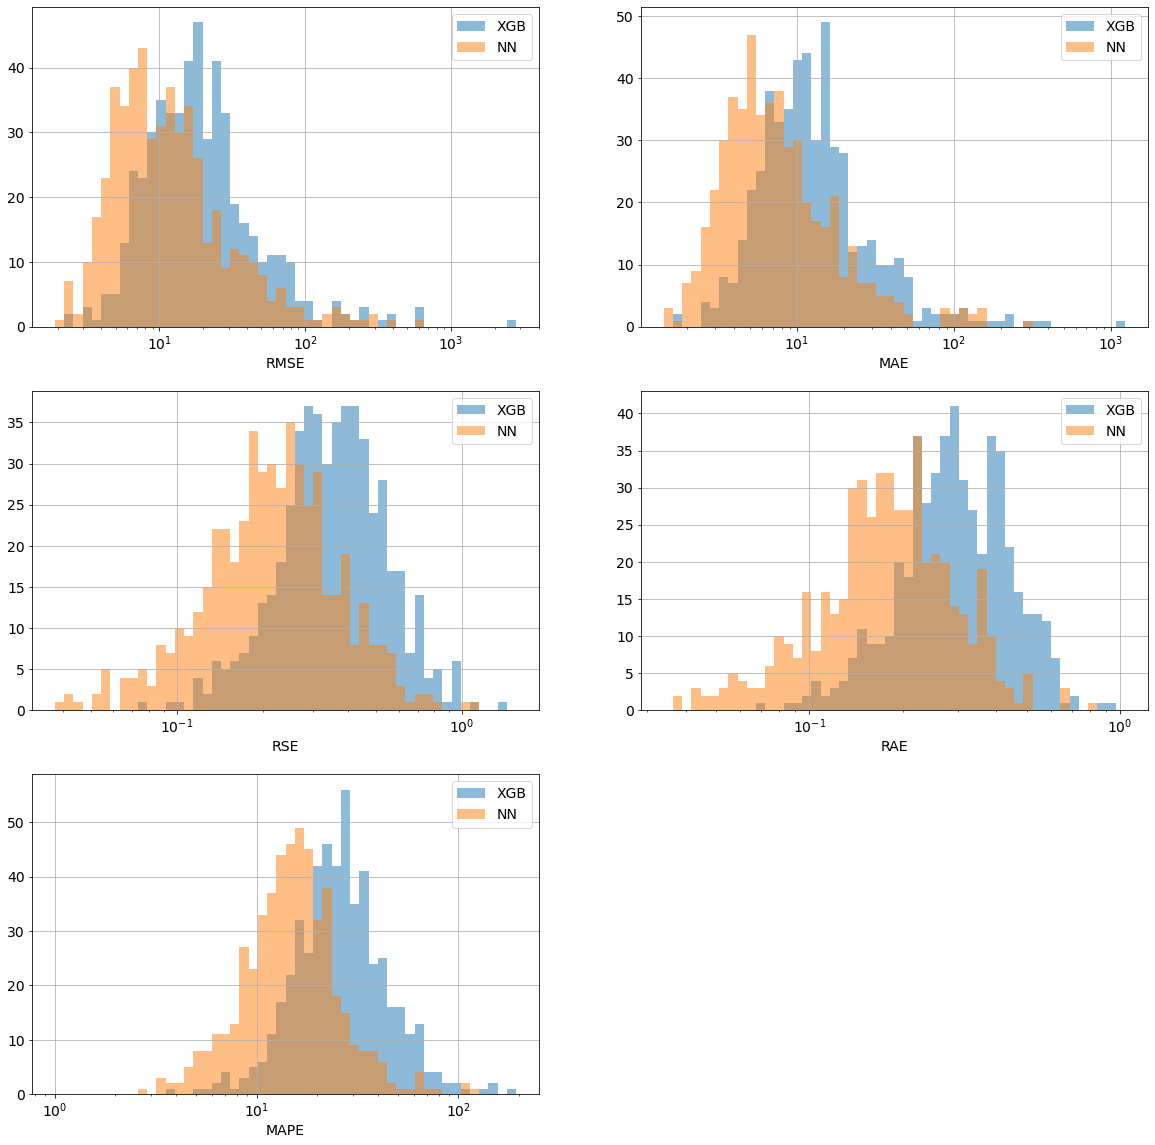

In [120]:
plot_mult_metrics_histogram([xgb_report, nn_report], ['XGB', 'NN'], bins=50)

# Linear regression with poly-features

In [139]:
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [174]:
linpoly_report = pd.DataFrame(columns=["ID", 'RMSE', 'MAE', 'RSE', 'RAE', 'MAPE'])

for i in tqdm.tqdm_notebook(good_object_ids):
    
    # get an object
    anobject = get_object(data, i)
    anobject = add_log_lam(anobject)
    
    # train / test split
    anobject_train, anobject_test = train_test_split(anobject, test_size=0.5, random_state=11)
    
    X_train = anobject_train[['mjd', 'log_lam']].values
    X_test  = anobject_test[['mjd', 'log_lam']].values

    y_train = anobject_train['flux'].values
    y_test  = anobject_test['flux'].values

    X_train_ss = X_train
    X_test_ss = X_test

    # fit a regression model to approximate light curves
    reg = make_pipeline(
        StandardScaler(),
        PolynomialFeatures(4, include_bias=False),
        linear_model.Ridge()
    )
    reg.fit(X_train_ss, y_train)

    
    # predict flux for unseen observations
    anobject_test_pred = anobject_test.copy()
    anobject_test_pred['flux'] = np.maximum(reg.predict(X_test_ss), 0)
    
    metrics = utils.regression_quality_metrics_report(anobject_test['flux'].values, anobject_test_pred['flux'].values)
    linpoly_report.loc[len(linpoly_report), :] = [i] + list(metrics)
np.round(linpoly_report.mean(), 2)

ID      340898.23
RMSE        40.81
MAE         27.93
RSE          0.38
RAE          0.33
MAPE        40.09
dtype: float64

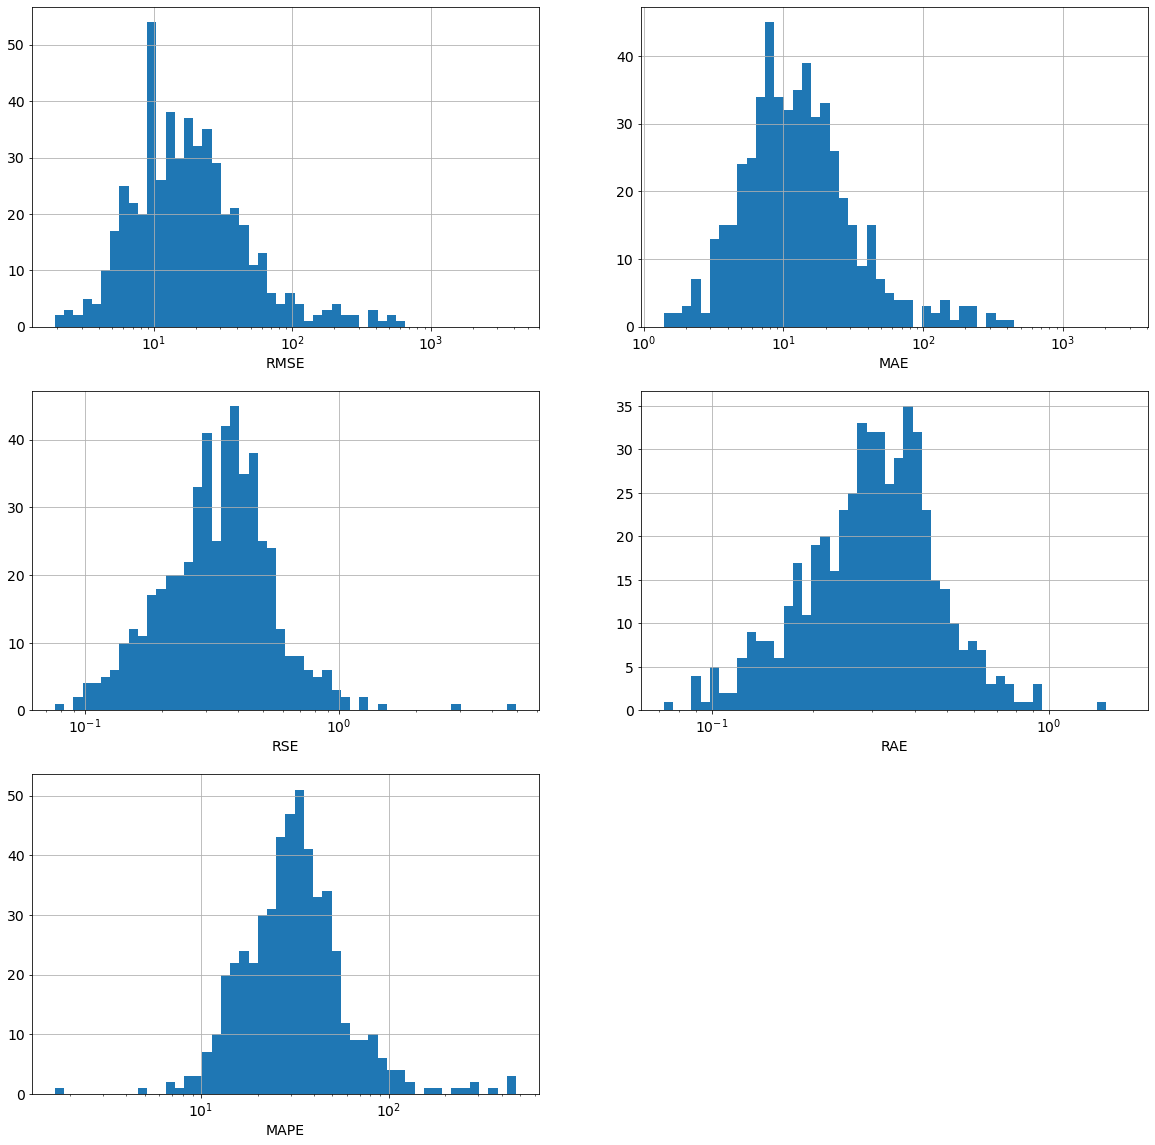

In [175]:
plot_metrics_histogram(linpoly_report)

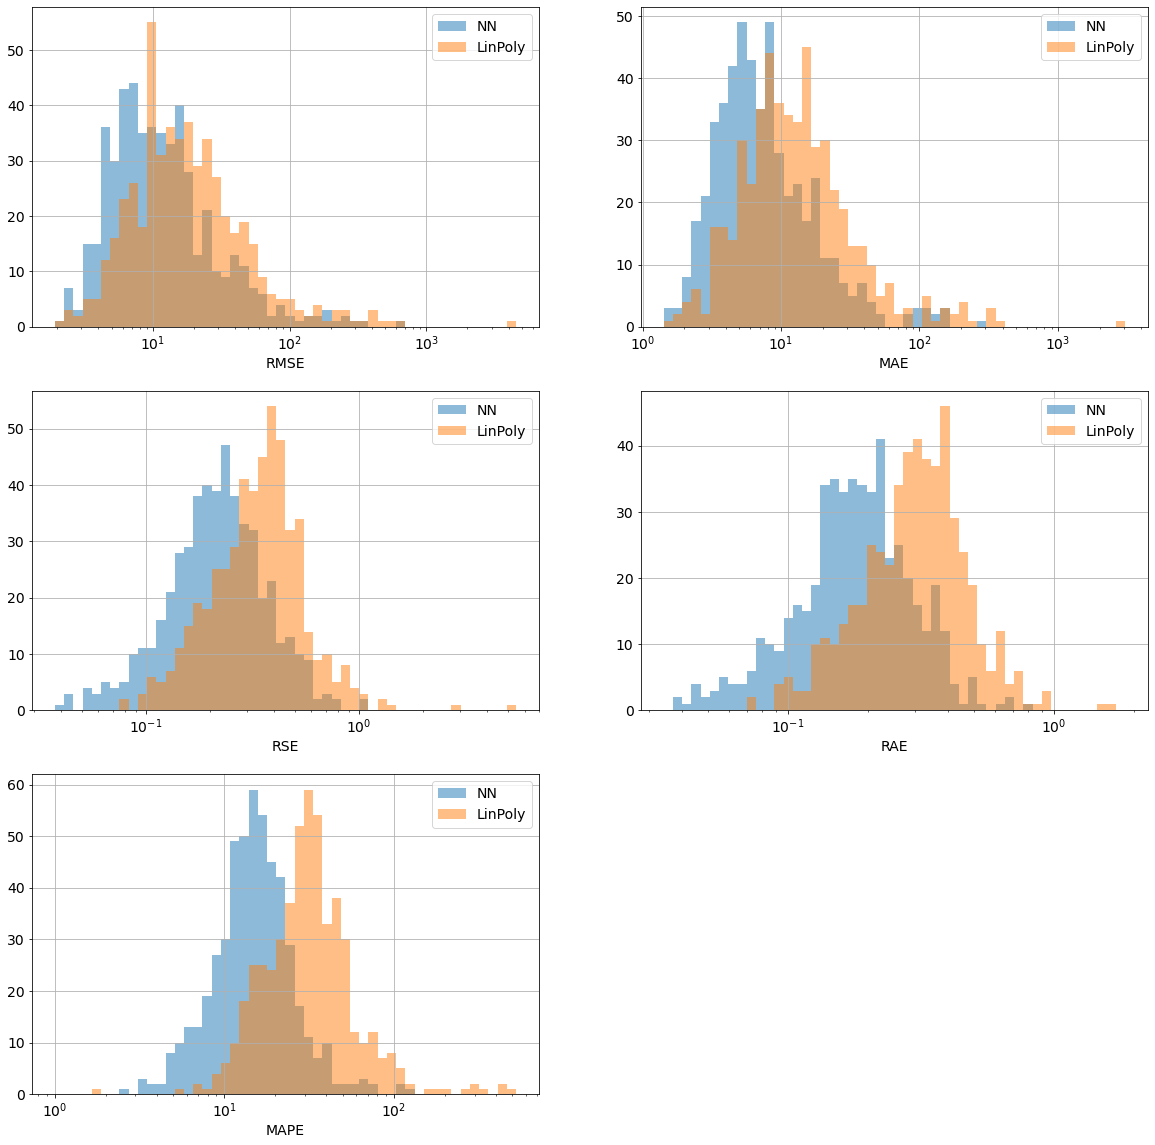

In [180]:
plot_mult_metrics_histogram([nn_report, linpoly_report],
                            ['NN', 'LinPoly'], bins=50)

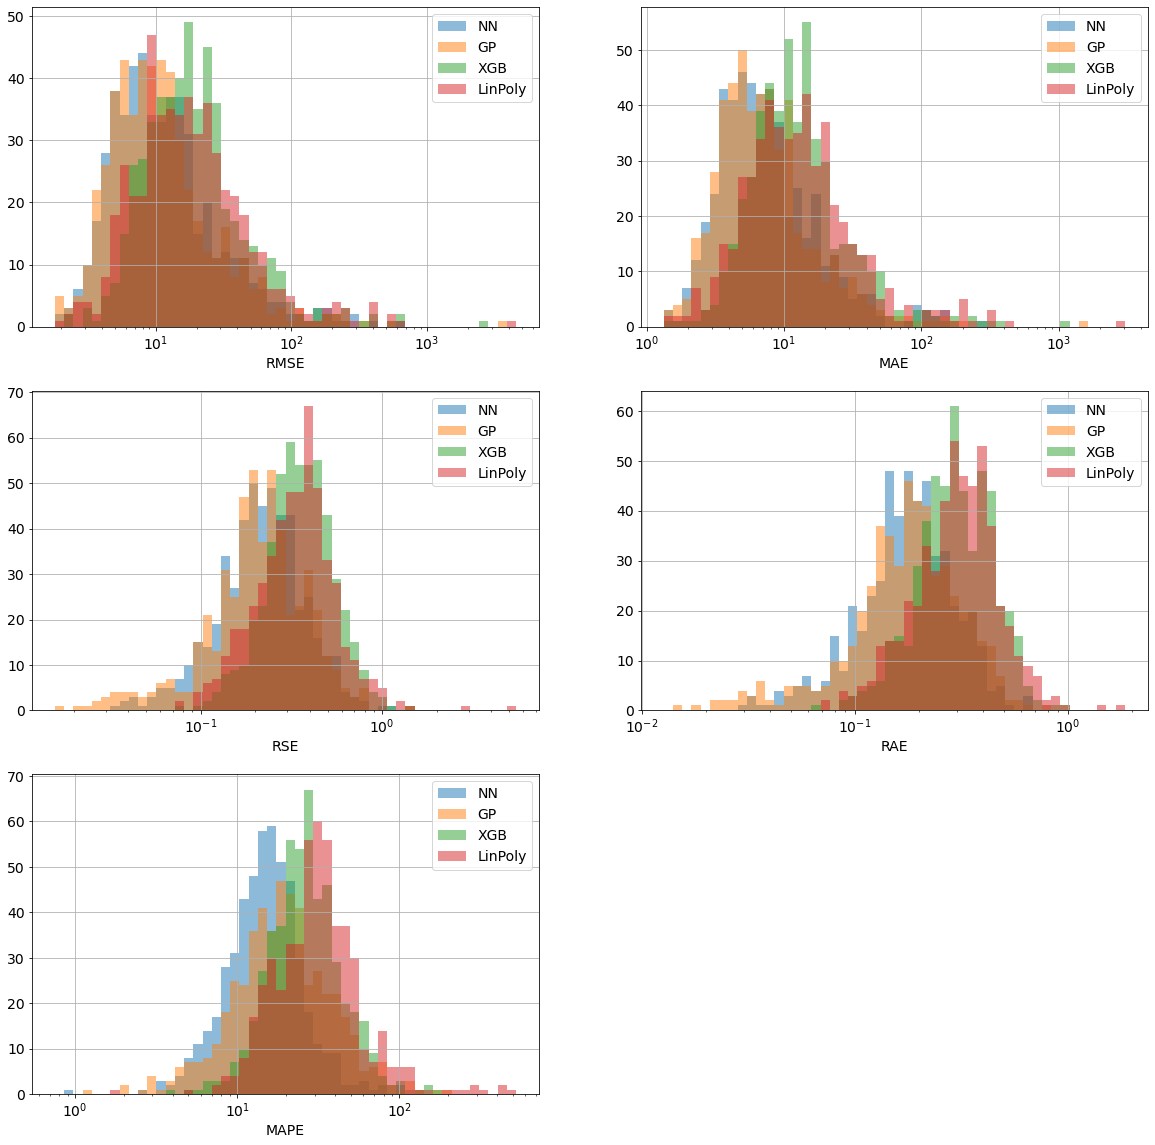

In [181]:
plot_mult_metrics_histogram([nn_report, gp_report, xgb_report, linpoly_report],
                            ['NN', 'GP', 'XGB', 'LinPoly'], bins=50)

# Approximations comparison

In [178]:
def plot_light_curves_compare(orig_object, approx_objects, titles=None):
    if titles is None:
        titles = [""] * (1 + len(approx_objects))
    plot_light_curves(orig_object, titles[0])
        
    plt.figure(figsize=(20, 4))
    n_obj = len(approx_objects)
    for idx, anobject in enumerate(approx_objects, 1):
        plt.subplot(1, n_obj, idx)
        anobject = anobject.sort_values('mjd')
        for passband in range(6):
            light_curve = get_passband(anobject, passband)
            plt.plot(light_curve['mjd'].values, light_curve['flux'].values, linewidth=0.5)
            plt.scatter(light_curve['mjd'].values, light_curve['flux'].values, label=passband2name[passband], linewidth=1)
        plt.xlabel('Modified Julian Date', size=14)
        plt.xticks(size=14, rotation=45)
        plt.ylabel('Flux', size=14)
        plt.yticks(size=14)
        plt.legend(loc='best', ncol=3, fontsize=14)
        plt.title(titles[idx], size=14)
    plt.show()
    
def approximate_model(reg, anobject):
    X = anobject[['mjd', 'log_lam']].values
    y  = anobject['flux'].values
    ss = StandardScaler()
    X_ss = ss.fit_transform(X)
    reg.fit(X_ss, y)

    approx_object = create_approx_object(anobject)
    X = approx_object[['mjd', 'log_lam']].values
    X_ss = ss.transform(X)
    approx_object['flux'] = np.maximum(reg.predict(X_ss), 0)
    
    return approx_object

34299


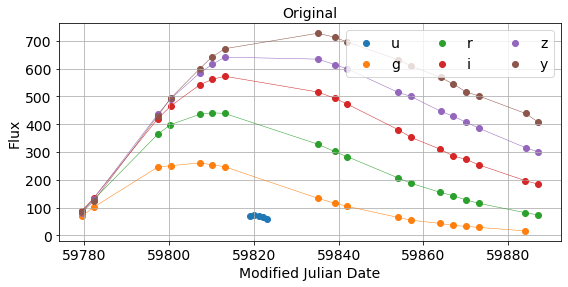

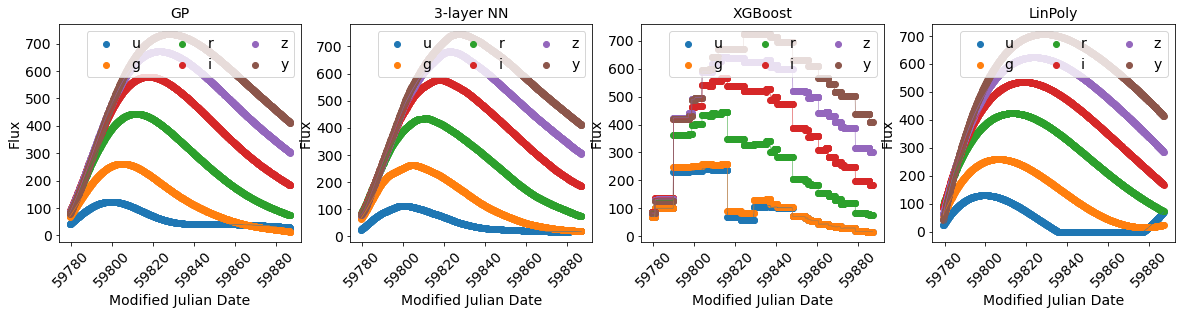

43812


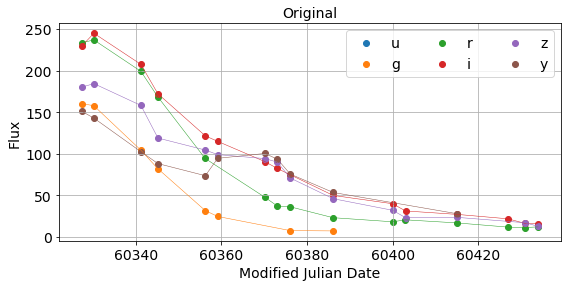

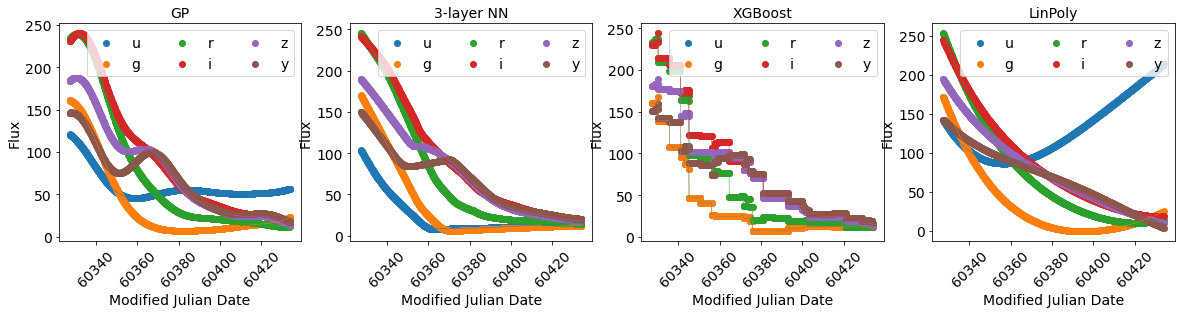

70046


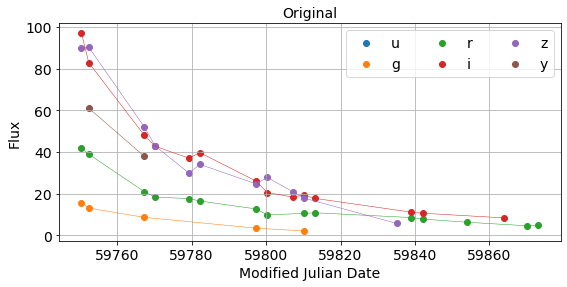

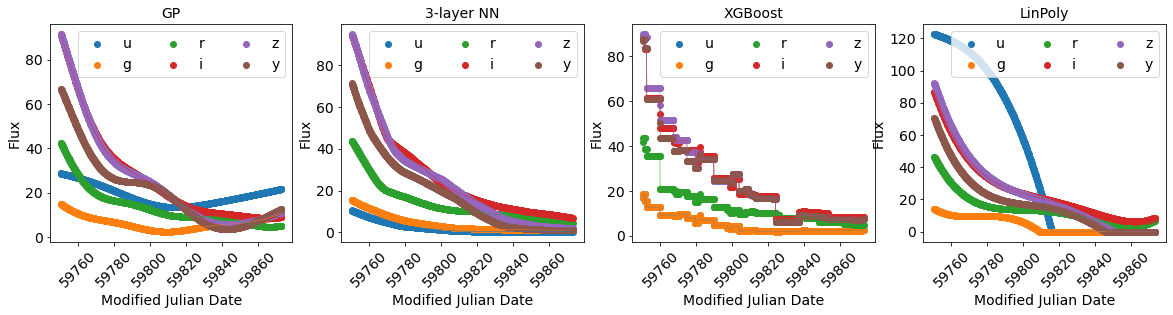

84716


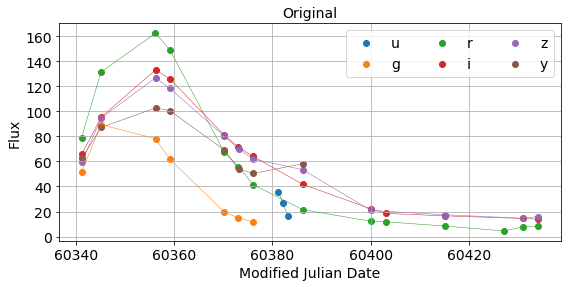

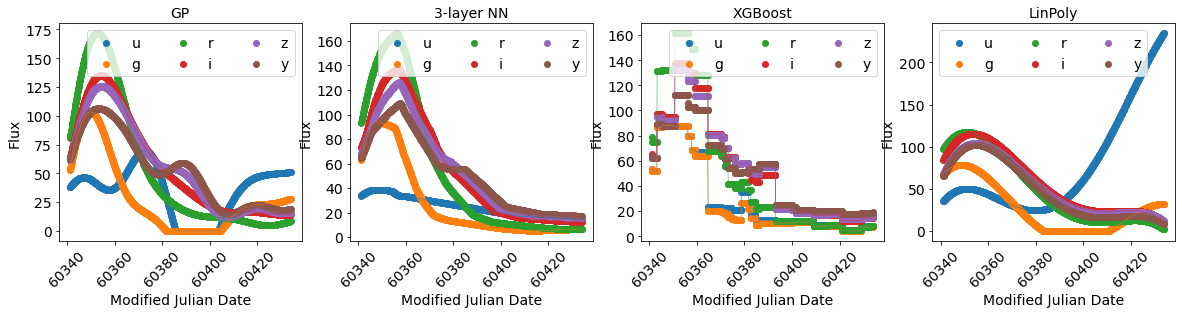

131629


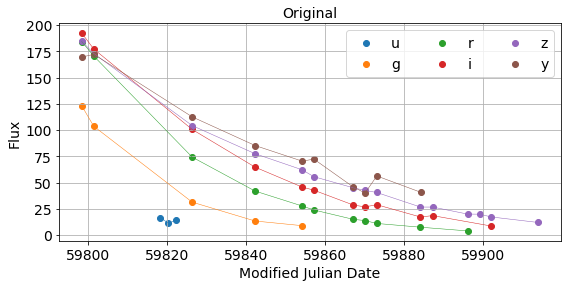

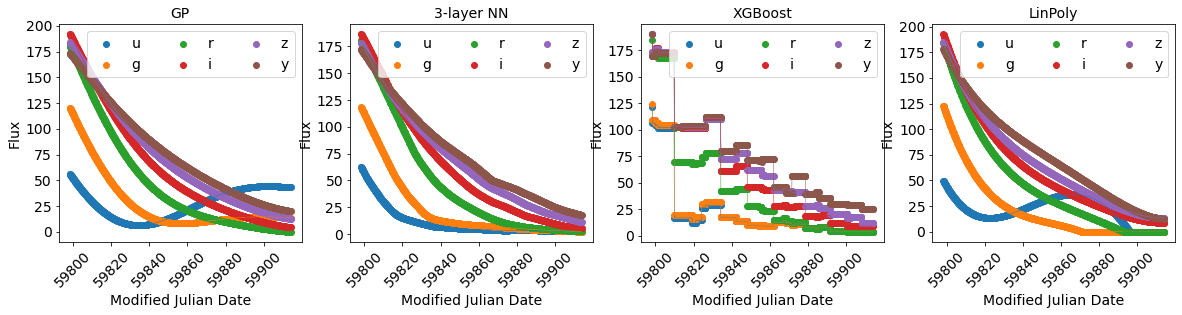

169315


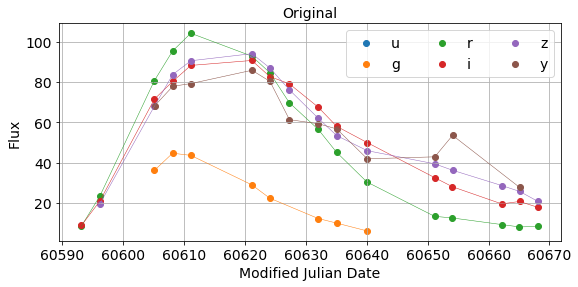

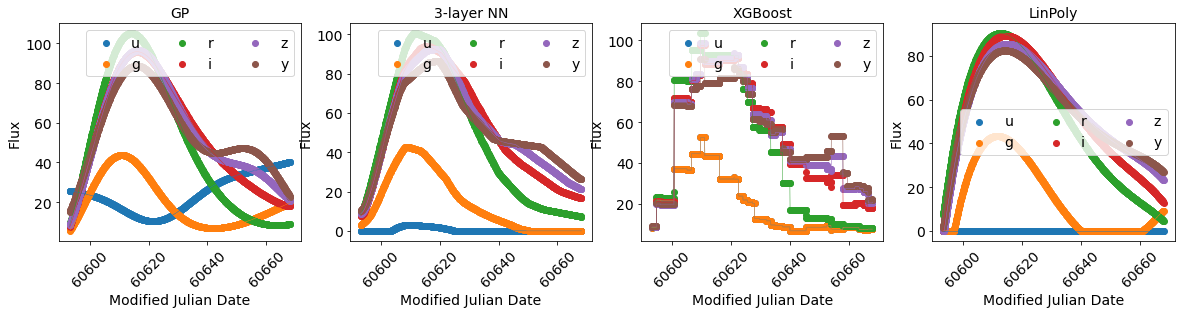

229855


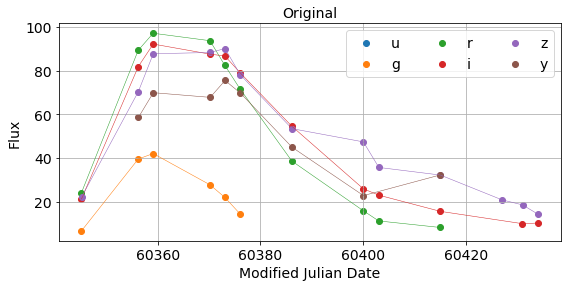

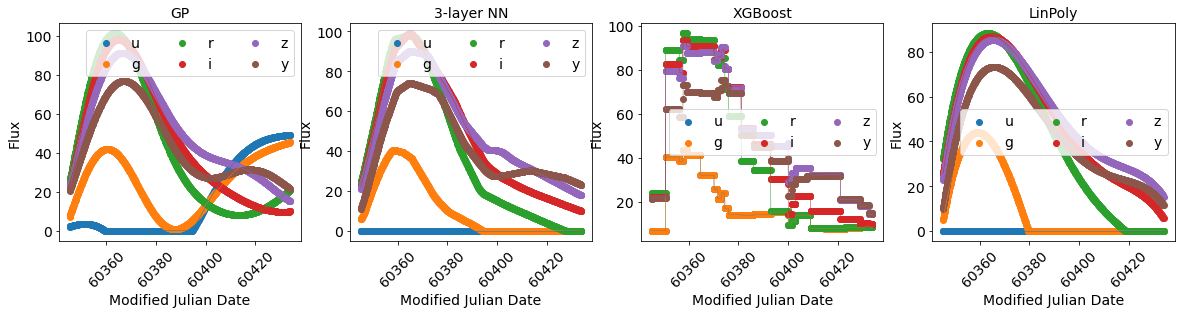

251430


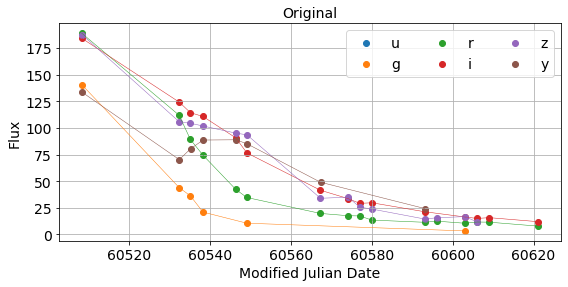

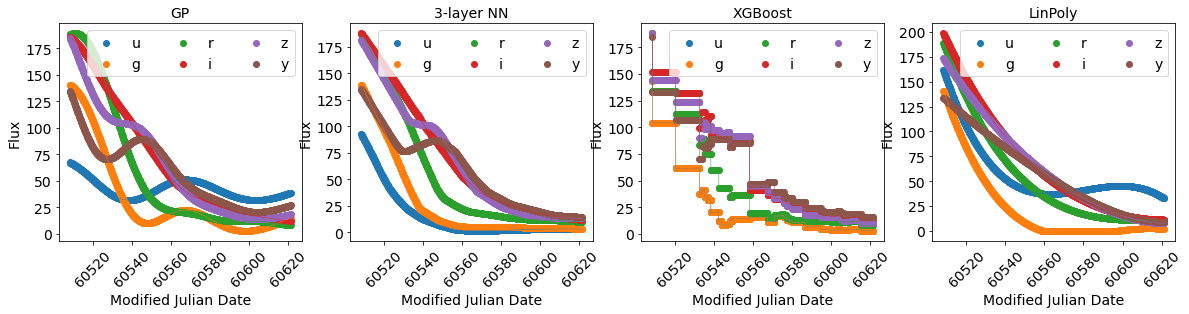

282714


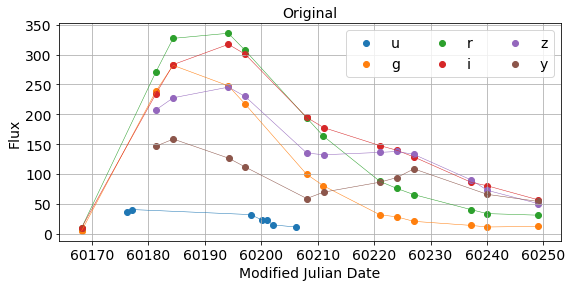

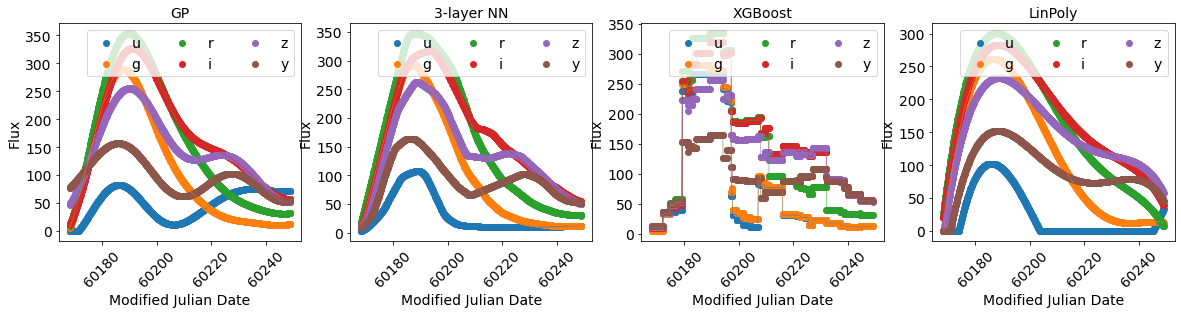

290682


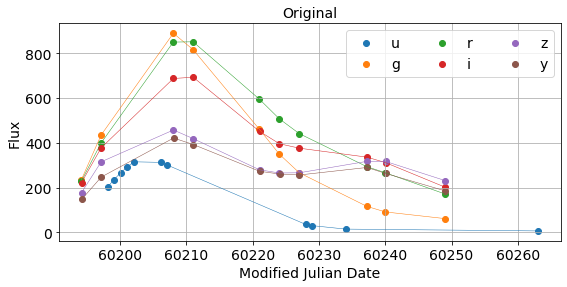

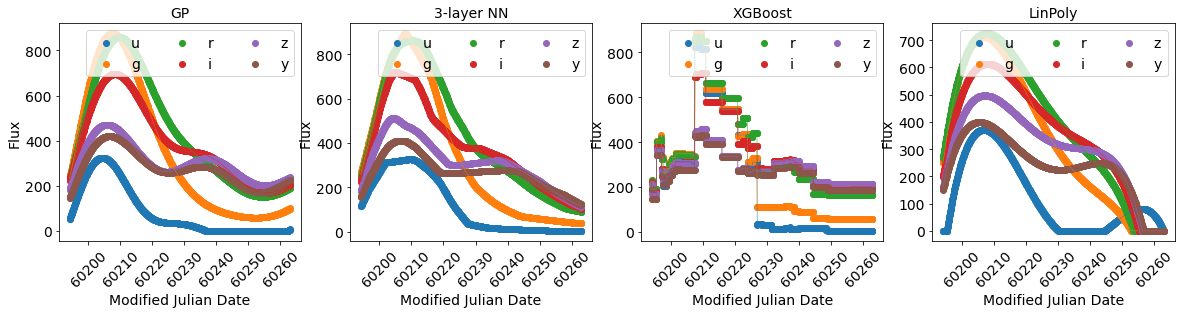

316306


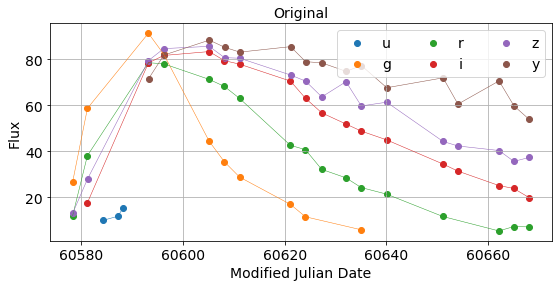

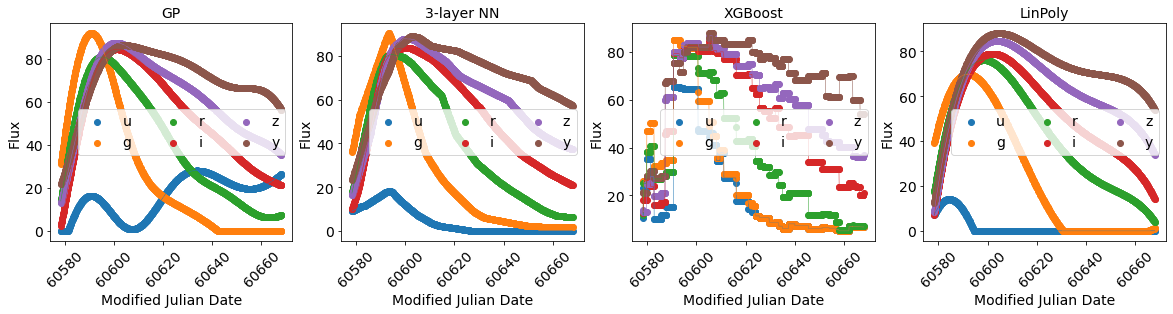

In [179]:
kernel = C(1.0) * RBF([1.0, 1.0]) + WhiteKernel()
regs = [
    GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=5, optimizer="fmin_l_bfgs_b", random_state=42),
    regressor.FitNNRegressor(n_hidden=300, n_epochs=200, batch_size=200, lr=0.1, lam=0.1, optimizer='Adam', debug=0),
    XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, objective='reg:squarederror'),
    make_pipeline(
        PolynomialFeatures(4, include_bias=False),
        linear_model.Ridge()
    )
]
for i in object_ids[::50]:
    anobject = get_object(data, i)
    anobject = add_log_lam(anobject)

    if not is_good(anobject): continue
    print(i)

    objects = [approximate_model(reg, anobject) for reg in regs]
    
    plot_light_curves_compare(anobject, objects, ['Original', 'GP', '3-layer NN', 'XGBoost', 'LinPoly'])
    plt.show()